# Popular Data Science Questions

In this guided project we will be exploring the Data Science Stack Exchange website and we will pinpoint the most popular content that is being talked about. 

First, we will query the DSSE database to retrieve a csv file about all posts in 2019 pertaining to the  CreationDate, Score, ViewCount, Tags, AnswerCount, FavoriteCount columns. The following is the SQL Quary we used.

SELECT CreationDate, Score, ViewCount, Tags, AnswerCount,FavoriteCount
FROM posts
WHERE CreationDate >= '2019-01-01' AND  CreationDate <= '2019-12-31'

### Importing Tools and Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
questions = pd.read_csv("2019_questions.csv", parse_dates=["CreationDate"])

### Exploring the Data

- The column 'FavoriteCount' contains a large number of null values in our dataset, about 75% are null values
- We can fill in these values with 0
- The datatypes correspond corretly to the columns after we run the .info() method
- We can remove the brackets from the Tags column and replace them with multi index tupules, nother option would be to remove the brackets and replace them with a delimiter such as a ",".


In [3]:
questions.head()

,Id,CreationDate,Score,ViewCount,Tags,AnswerCount,FavoriteCount
0,44419,2019-01-23 09:21:13,1,21,<machine-learning><data-mining>,0,NaN
1,44420,2019-01-23 09:34:01,0,25,<machine-learning><regression><linear-regressi...,0,NaN
2,44423,2019-01-23 09:58:41,2,1651,<python><time-series><forecast><forecasting>,0,NaN
3,44427,2019-01-23 10:57:09,0,55,<machine-learning><scikit-learn><pca>,1,NaN
4,44428,2019-01-23 11:02:15,0,19,<dataset><bigdata><data><speech-to-text>,0,NaN


In [4]:

questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    1407 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


### Cleaning the Dataset

In [5]:
# Replace NaN values with 0 inside the FavoriteCount column
questions["FavoriteCount"].fillna(0,inplace= True)

In [6]:
# Change the float type to an int inside the FavoriteCount column
questions["FavoriteCount"]= questions["FavoriteCount"].astype(int)
questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
Id               8839 non-null int64
CreationDate     8839 non-null datetime64[ns]
Score            8839 non-null int64
ViewCount        8839 non-null int64
Tags             8839 non-null object
AnswerCount      8839 non-null int64
FavoriteCount    8839 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 483.5+ KB


Next, we remove the "<" and ">" from the Tags column and place a "," as a delimiter between each individual topic

In [7]:
questions["Tags"] = questions["Tags"].str.replace("><",",").str.replace("<","").str.replace(">","")
questions["Tags"].head()

0                         machine-learning,data-mining
1    machine-learning,regression,linear-regression,...
2              python,time-series,forecast,forecasting
3                    machine-learning,scikit-learn,pca
4                  dataset,bigdata,data,speech-to-text
Name: Tags, dtype: object

### Visualizing Tags by Popularity

We will visualize Tag popularity in two ways:
- Frequency of tags used
- View count for each tag type

#### I. Tags vs Tag Frequency

In [8]:
# Split all tags using the "," as a delimiter first, this will create a list of tags in each row
questions["Tags"]=questions["Tags"].str.split(",")

In [9]:
# This funtion will return a dctionary of each topics frequency count
tag_count = {}
def get_type(row):        
    array_tags=row["Tags"]#.split(",")
    
    for tag in array_tags:
        if tag not in tag_count:
            tag_count[tag] = 1
        else:
            tag_count[tag] += 1

In [10]:
show_type = questions.apply(get_type, axis = 1)

In [11]:
tag_count_series = pd.Series(tag_count)
tag_count_series.sort_values(ascending = False).head(10)

machine-learning    2693
python              1814
deep-learning       1220
neural-network      1055
keras                935
classification       685
tensorflow           584
scikit-learn         540
nlp                  493
cnn                  489
dtype: int64

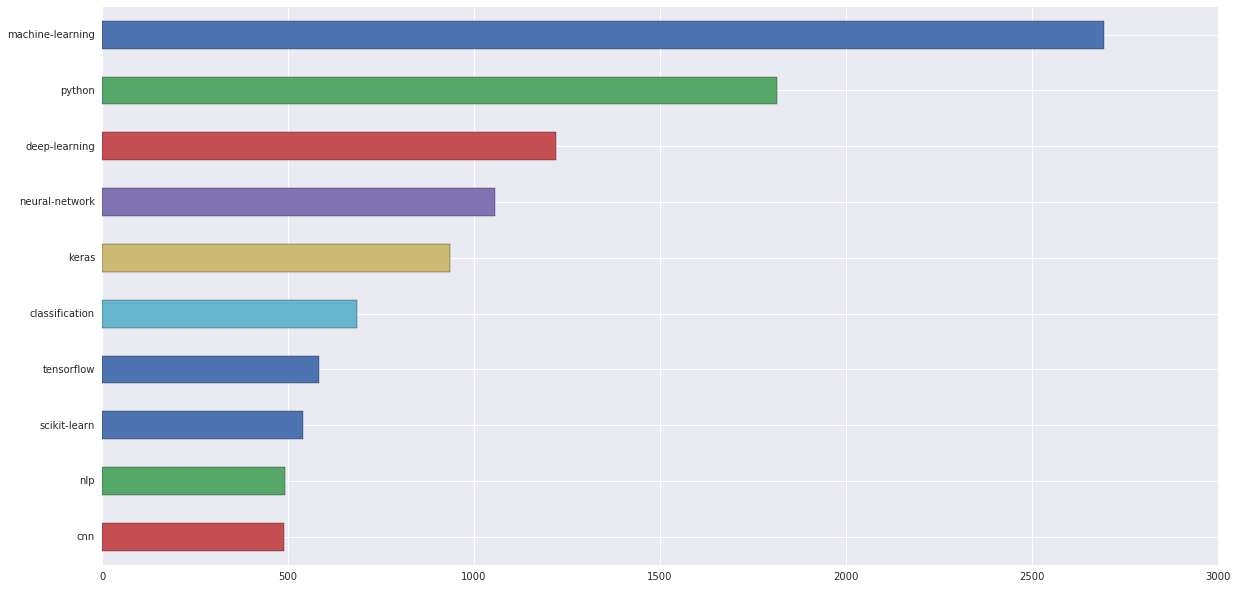

In [12]:
plot_data_top_10 = tag_count_series.sort_values(ascending = False).head(10)
plot_data_top_10.plot(kind = "barh", figsize =(20,10)).invert_yaxis()

plt.show()

#### II. Tags vs Tag Views

In [13]:
tag_view_dict = {}
def get_views(row):        
    array_tags=row["Tags"]
    
    for tag in array_tags:
        #print(array_tags)
        if tag not in tag_view_dict:
            tag_view_dict[tag] = row["ViewCount"]
        else:
            tag_view_dict[tag] += row["ViewCount"]

In [14]:
view_type = questions.apply(get_views, axis = 1)
#print(tag_view_dict)

In [15]:
tag_views_series = pd.Series(tag_view_dict)
top_10_viewed = tag_views_series.sort_values(ascending = False).head(10)

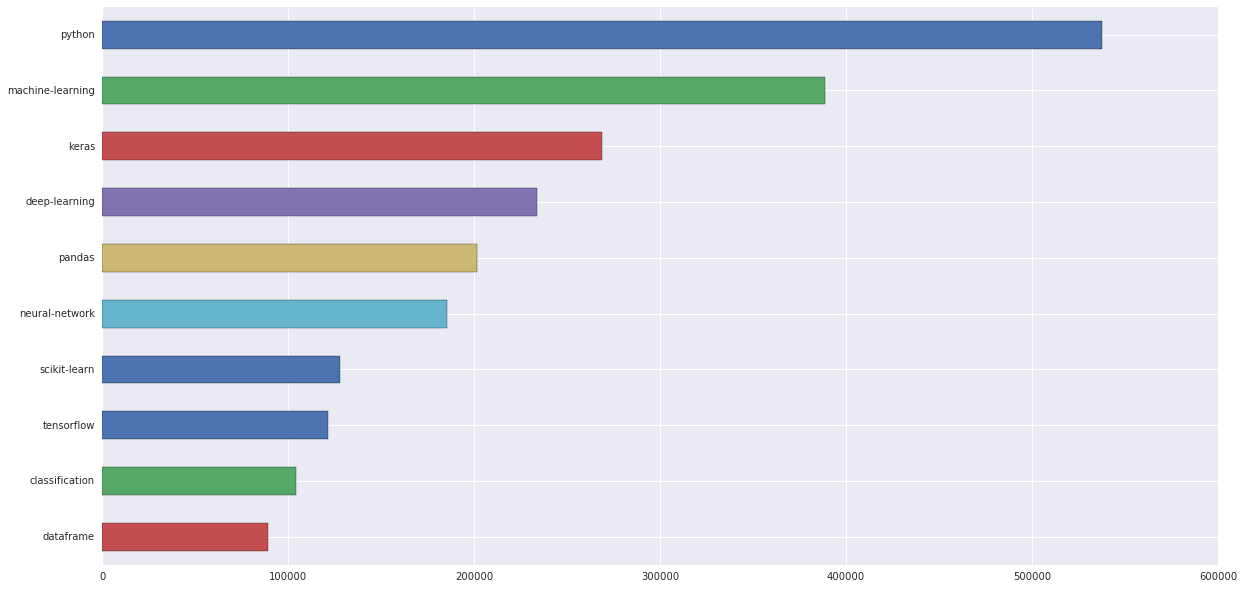

In [16]:
top_10_viewed.plot(kind = "barh", figsize =(20,10)).invert_yaxis()
plt.show()

#### III. Merging Most Views with Most Tags

In [17]:
most_tags= pd.DataFrame(tag_count_series)
most_views = pd.DataFrame(tag_views_series)

merged_df = pd.merge(most_tags,most_views,"left",left_index=True,right_index=True)

In [18]:
merged_df.head(10)

,0_x,0_y
.net,1,438
3d-object-detection,1,7
3d-reconstruction,9,1129
ab-test,6,153
accuracy,89,15233
activation,1,15
activation-function,44,13121
active-learning,4,155
activity-recognition,5,126
actor-critic,21,1014


### Finding Associations Between Tags

Let us find a correlation of which tags appear togather most. For this purpose we will construct a co-occurence heatmap in the following steps:

- Create a co-occurence table by using a nested for loop to count how many times pairs of tags appear in the same tags array/row
- Create a table of correlations using the indeces of the top 10 most viewed results.

In [24]:
all_tags = list(most_tags.index)
associations = pd.DataFrame(index=all_tags, columns=all_tags)
associations.head(20)

associations.fillna(0, inplace=True)

# Pandas powerful alternative to this nested for loop is:
# Alternative is associations.loc[row, row] += 1
for row in questions["Tags"]:
    for tag in row:
        associations.loc[row, tag] += 1


#Testing a sample from our data and comparing it to the official answer yields a corrent result:
locate_data = associations.loc["r","statistics"]
print(locate_data)

16


In [25]:
associations.head(20)

,.net,3d-object-detection,3d-reconstruction,ab-test,accuracy,activation,activation-function,active-learning,activity-recognition,actor-critic,...,weighted-data,weka,wikipedia,wolfram-language,word,word-embeddings,word2vec,xboost,xgboost,yolo
.net,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3d-object-detection,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3d-reconstruction,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab-test,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accuracy,0,0,0,0,89,0,0,0,0,0,...,0,0,0,0,0,0,1,0,3,0
activation,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
activation-function,0,0,0,0,0,0,44,0,0,0,...,1,0,0,0,0,0,1,0,0,0
active-learning,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
activity-recognition,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,0,0,0,0,0,0
actor-critic,0,0,0,0,0,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# The dataframe above is too large and contains a lot of empty data points.
# So we will use the tags of the most popular columns to extract a meanignful dataframe of results:

tags_relationship = associations.loc[plot_data_top_10.index, plot_data_top_10.index]
relations_most_used.head(20)

NameError: name 'relations_most_used' is not defined

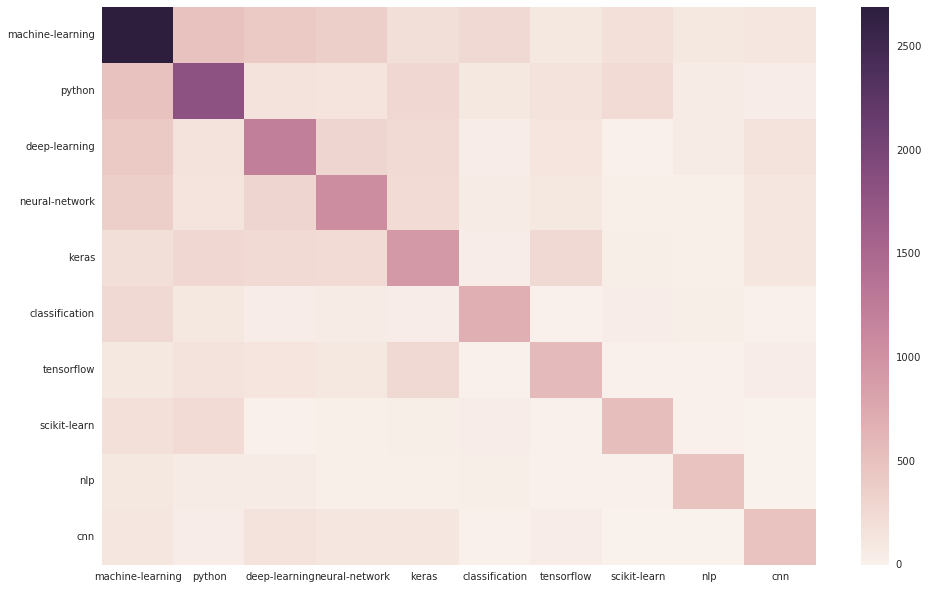

In [27]:
plt.figure(figsize=(16,10))
sns.heatmap(tags_relationship)

When analyzing the heatmap we can see that Python/deep-learning/neural network/ Keras/ Classification and scikit-learn are clustered together the most, and appear to show up most in the same tags.

### Is Deep Learning Just a Fad?

In this section we will be pondering the question: "Is deep learning just a fad?". TO answer this question we will use the "al_questions.csv" dataset which contains the same Tags we have used so far but numbered by CreationDate.

Steps taken:
- Crete a new dataframe copy with an extra column that contains a value of 1 if the Tags are related to a deep learning question.
- Drop all rows with 0 in them
- Create a bar chart to visualize the results by year.


In [28]:
# Import or dataset:
all_quest = pd.read_csv("all_questions.csv")

In [29]:
#Copy the dataframe
all_quest.shape
deep_df = all_quest.copy()

#Explore the top 5 rows:
deep_df.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


In [30]:
# Clean the dataframe tags:
deep_df["Tags"] = deep_df["Tags"].str.replace("><",",").str.replace("<","").str.replace(">","")
# Check if the tags were cleaned properly:
deep_df.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"python,keras,tensorflow,cnn,probability"
1,45418,2019-02-12 00:50:39,neural-network
2,45422,2019-02-12 04:40:51,"python,ibm-watson,chatbot"
3,45426,2019-02-12 04:51:49,keras
4,45427,2019-02-12 05:08:24,"r,predictive-modeling,machine-learning-model,s..."


In [31]:
# Turn the rows into lists that we can iterate over later
deep_df["Tags"]=deep_df["Tags"].str.split(",")
deep_df.head()

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]"
1,45418,2019-02-12 00:50:39,[neural-network]
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]"
3,45426,2019-02-12 04:51:49,[keras]
4,45427,2019-02-12 05:08:24,"[r, predictive-modeling, machine-learning-mode..."


In [32]:
# The kewrods that we will use to associate with deep learning are "machine-learning","python","deep-learning","neural-network","keras","tensorflow","cnn"

keywords = ["machine-learning","python","deep-learning","neural-network","keras","tensorflow","cnn"]
def replace_keywords(row):
    for tag in row["Tags"]:
        #print(tag)
        if tag in keywords:
            #print(tag)
            return 1
        else:
            return 0

We then apply our custom function to the dataframe and use boolean indexing to extract a dataframe that contains tags related to deep learning only.

In [33]:
deep_df["deep_learning_questions"] = deep_df.apply(replace_keywords, axis =1)

In [34]:
clean_deep= deep_df[deep_df["deep_learning_questions"] == 1]
clean_deep.head()

,Id,CreationDate,Tags,deep_learning_questions
0,45416,2019-02-12 00:36:29,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02-12 00:50:39,[neural-network],1
2,45422,2019-02-12 04:40:51,"[python, ibm-watson, chatbot]",1
3,45426,2019-02-12 04:51:49,[keras],1
5,45428,2019-02-12 05:43:18,[cnn],1


In [35]:
clean_deep2 = clean_deep.copy()
clean_deep2["CreationDate"] = pd.to_datetime(clean_deep2["CreationDate"])


In [36]:

clean_deep2["CreationDate"] = clean_deep2["CreationDate"].dt.to_period('M')


In [37]:
clean_deep2.head()

,Id,CreationDate,Tags,deep_learning_questions
0,45416,2019-02,"[python, keras, tensorflow, cnn, probability]",1
1,45418,2019-02,[neural-network],1
2,45422,2019-02,"[python, ibm-watson, chatbot]",1
3,45426,2019-02,[keras],1
5,45428,2019-02,[cnn],1


In [38]:
plot_data = clean_deep2["CreationDate"].dt.year.value_counts()
plot_data= plot_data.sort_index(ascending = True)

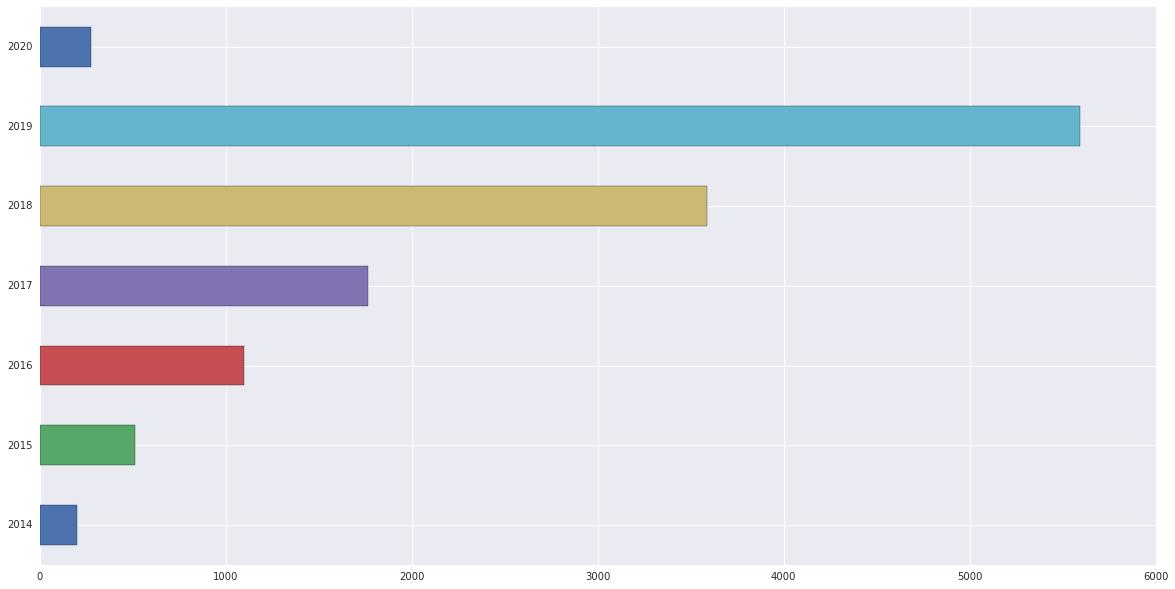

In [39]:
plot_data.plot(kind = "barh", figsize =(20,10))

We can see that the number of questions pertainng to Deep Learning is rising constantly every year. The outlier in the year 2020 is due to incomplete data in our csv file, so we can drop results that are 2020 and over.